## 1- We start by installing the required modules:

In [ ]:
pip install -r requirements.txt

## 2- Then we load the "Adult Census Income" dataset available publicly on: https://archive.ics.uci.edu/dataset/2/adult

In [2]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
adult = fetch_ucirepo(id=2)

# data (as pandas dataframes)
X = adult.data.features
y = adult.data.targets

# metadata
print(adult.metadata)

# variable information
print('\n\n', adult.variables)


{'uci_id': 2, 'name': 'Adult', 'repository_url': 'https://archive.ics.uci.edu/dataset/2/adult', 'data_url': 'https://archive.ics.uci.edu/static/public/2/data.csv', 'abstract': 'Predict whether annual income of an individual exceeds $50K/yr based on census data. Also known as "Census Income" dataset. ', 'area': 'Social Science', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 48842, 'num_features': 14, 'feature_types': ['Categorical', 'Integer'], 'demographics': ['Age', 'Income', 'Education Level', 'Other', 'Race', 'Sex'], 'target_col': ['income'], 'index_col': None, 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 1996, 'last_updated': 'Tue Sep 24 2024', 'dataset_doi': '10.24432/C5XW20', 'creators': ['Barry Becker', 'Ronny Kohavi'], 'intro_paper': None, 'additional_info': {'summary': "Extraction was done by Barry Becker from the 1994 Census database.  A set of reasonably clean records was extracted using the fol

### Above, some meta data about the dataset can be seen. There are a total of 14 predictos (= variables) inside the X and a target variable (= label) denoted by y, which shows whether the annual income of individuals was greater than 50K USD.
### Then we from our dataframe by concatanating X and y as below:

In [3]:
import pandas as pd
df = pd.concat([X,y], axis = 1);
print(f'dataframe shape is: {df.shape}\n')
print(f'The columns of the dataframe are : {df.columns.values}')

dataframe shape is: (48842, 15)

The columns of the dataframe are : ['age' 'workclass' 'fnlwgt' 'education' 'education-num' 'marital-status'
 'occupation' 'relationship' 'race' 'sex' 'capital-gain' 'capital-loss'
 'hours-per-week' 'native-country' 'income']


### In order to formulate our causal question, first we extract the unique values within the variable `"occupation"` :

In [4]:
df['occupation'].value_counts()

Prof-specialty       6172
Craft-repair         6112
Exec-managerial      6086
Adm-clerical         5611
Sales                5504
Other-service        4923
Machine-op-inspct    3022
Transport-moving     2355
Handlers-cleaners    2072
?                    1843
Farming-fishing      1490
Tech-support         1446
Protective-serv       983
Priv-house-serv       242
Armed-Forces           15
Name: occupation, dtype: int64

### Therefore, there are a total of 6086 instances who have the value `Exec-managerial` for their "occupation".
### Now, the question is: would being an Executive Manager have any impact on a person’s income? In other words, considering being an Executive Manager as a **“treatment”**, what would be its causal effect on a person’s income? Would somebody earn more money (or have higher chances to earn above 50K USD) because he/she became an Executive Manager or is there any other factor (i.e., a confounder) influencing both occupation and the higher income?


## The Model:
### One of the key parts when doing causal inference is modelling the problem. Here, based on some domain knowledge, we choose the causal model to be of this form:
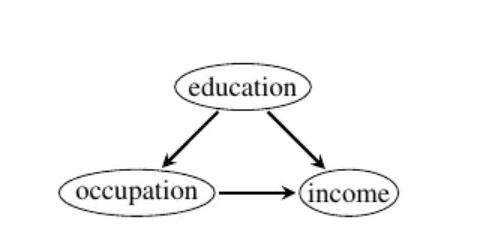


### Now, according to the model above, we pick the only 3 relevant varaiables:

In [5]:
#Select desired columns
input_data = {'education': df.loc[:, 'education'],
              'occupation': df.loc[:, 'occupation'],
              'income': df.loc[:, 'income']
             }

df = pd.DataFrame(input_data)
df.shape, df.columns

((48842, 3), Index(['education', 'occupation', 'income'], dtype='object'))

In [6]:
df.isna().sum()

education       0
occupation    966
income          0
dtype: int64

### However, we still have some missing values within this new dataframe, so I basically removed all these 966 missing values from the dataset, as they were only a small part of the dataset:

In [7]:
df = df.dropna()
print(f'The dataframe size after imputing missings is: {df.shape}')

The dataframe size after imputing missings is: (47876, 3)


In [8]:
# Make occupation column binary (Default or Exec-managerial) to "induce" the treatment 
for index, row in df.iterrows():
    if row['occupation'] != "Exec-managerial":
        row['occupation'] = "Default"

In [9]:
df['occupation'].value_counts()

Default            41790
Exec-managerial     6086
Name: occupation, dtype: int64

In [10]:
df['income'].value_counts()

<=50K     24720
<=50K.    11543
>50K       7841
>50K.      3772
Name: income, dtype: int64

### As seen above, there seems to be some incorrect records under the column `income` since there are different records for distinct values of "<=50K" and "<=50K." so we have to aggragate them: 

In [11]:
df.loc[df['income'] == '<=50K.', 'income'] = '<=50K'
df.loc[df['income'] == '>50K.', 'income'] = '>50K'

In [12]:
df['income'].value_counts()

<=50K    36263
>50K     11613
Name: income, dtype: int64

In [13]:
df.head()

,education,occupation,income
0,Bachelors,Default,<=50K
1,Bachelors,Exec-managerial,<=50K
2,HS-grad,Default,<=50K
3,11th,Default,<=50K
4,Bachelors,Default,<=50K


In [14]:
df = pd.get_dummies(df, columns=['income', 'occupation'], drop_first=True)
df.head()

,education,income_>50K,occupation_Exec-managerial
0,Bachelors,0,0
1,Bachelors,0,1
2,HS-grad,0,0
3,11th,0,0
4,Bachelors,0,0


### For the sake of brevity, I changed the names of the columns to the shorter versions:

In [15]:
df.columns=['education', 'income', 'occupation']

print(df.head())

   education  income  occupation
0  Bachelors       0           0
1  Bachelors       0           1
2    HS-grad       0           0
3       11th       0           0
4  Bachelors       0           0


### Now, let's instantiate our causal model in PyWhy:

In [16]:
import dowhy
from dowhy import CausalModel

graph_1 = """
    graph [
            directed 1

            node [id "education" label "education"]
            node [id "occupation" label "occupation"]
            node [id "income" label "income"]

            edge [source "education" target "occupation"]
            edge [source "education" target "income"]
            edge [source "occupation" target "income"]
            ]
"""

model_1 = CausalModel(
    data=df,
    treatment='occupation',
    outcome='income', 
    graph=graph_1
)

## The Estimand (= causal relationship whose strength will be estimated):
### Once we have a model for the problem (described as a causal graph), it is time to analyse its properties in order to identify the precise causal effect to be estimated. In other words, we want to identify the desired causal relationship in the causal graph to later estimate its strength.

In [17]:
estimand_1 = model_1.identify_effect()
print(estimand_1)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
      d                           
─────────────(E[income|education])
d[occupation]                     
Estimand assumption 1, Unconfoundedness: If U→{occupation} and U→income then P(income|occupation,education,U) = P(income|occupation,education)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



## The Estimation:
### Using the identified estimand (causal relationship), we can now calculate its strength. Here again we have multiple methods available (for more info on this, you can read more [here](https://medium.com/data-science-at-microsoft/causal-inference-part-2-of-3-selecting-algorithms-a966f8228a2d)). 
### I decided to stick with the linear regression method. The result tells us that on average the probability of an Executive Manager earning above 50K yearly was **~19%** higher in our dataset compared to other occupations.


In [18]:
estimate_1 = model_1.estimate_effect(
    identified_estimand=estimand_1,
    method_name='backdoor.linear_regression'
)

print(f'Estimate of causal effect: {estimate_1.value}')

Estimate of causal effect: 0.1906257228172796


## The Refutation:
### The final step in our analysis is to verify that the assumptions we made when we modelled the problem are valid. 
### The literature recommends doing more than one robustness check and indeed different methods are available in PyWhy (e.g., random common cause, placebo treatment refuter, data subset refuter).
### I decided to try the random common cause and placebo treatment refuter ones. For more info on these methods, one can refer to ["This Link"](https://medium.com/data-science-at-microsoft/causal-inference-part-3-of-3-model-validation-and-applications-c84764156a29).

### Random common cause adds an irrelevant common cause to our data and reruns the analysis to check whether the causal estimate changes or not. If our model was correct then the estimated value shouldn’t change significantly. That’s exactly what happened.

In [19]:
refute1_results = model_1.refute_estimate(estimand_1, estimate_1,
                                          method_name="random_common_cause"
                                         )

print(refute1_results)

Refute: Add a random common cause
Estimated effect:0.1906257228172796
New effect:0.1906195639473712
p value:0.84

